In [1]:
import numpy as np
import pandas as pd
import os

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('sander_final/rule_based_predictions.csv')
df.reset_index(drop=True, inplace=True)
df.drop(["fornafn", "millinafn", "eftirnafn", "aettarnafn", "uniqueness_score", "score", "id_individual"], axis=1, inplace=True)
df.tail() 

,id,manntal,nafn,faedingarar,kyn,stada,hjuskapur,bi_einstaklingur,bi_baer,bi_hreppur,bi_sokn,bi_sysla,cleaned_status
491129,780730,1801,Una Helge d,1800.0,Kona,deres datter,Ó,345456.0,9659.0,278.0,332.0,12,deres datter
491130,38269,1835,Ingibjörg Símonardóttir,1832.0,Kona,þeirra barn,Ó,345457.0,4453.0,278.0,334.0,12,Barn
491131,101212,1840,Ingibjörg Símonardóttir,1832.0,Kona,hans barn,Ó,345457.0,4442.0,275.0,331.0,12,Barn
491132,4592,1835,Helga Símonardóttir,1831.0,Kona,þeirra barn,Ó,345458.0,4453.0,278.0,334.0,12,Barn
491133,101210,1840,Helga Símonardóttir,1831.0,Kona,hans barn,Ó,345458.0,4442.0,275.0,331.0,12,Barn


In [14]:
print(len(df))

491134


In [15]:
intermediate_path = "intermediate_data/"

word2vec_model_path = os.path.join(intermediate_path, 'word2vec_model')
encoded_df_path = os.path.join(intermediate_path, 'encoded_df.pkl')
pairs_df_path = os.path.join(intermediate_path, 'pairs_df.pkl')
balanced_df_path = os.path.join(intermediate_path, 'balanced_df.pkl')

In [16]:
df = pd.read_pickle('intermediate_data/encoded_df.pkl')
X_train = np.load('intermediate_data/X_train.npy', allow_pickle=True)
X_train_df = pd.DataFrame(X_train)

####################################################################################################################

# Data Preprocessing Pipeline

## Step 1: Cleaning and Exclusion of Single-member Clusters

- **Total Single-member Clusters Excluded:** 120,112
- The cleaned dataset is saved after excluding these clusters.

## Step 2: Handling Missing and Redundant Columns

- **Dropped Columns:** Some columns like `fornafn`, `millinafn`, `eftirnafn`, `aettarnafn`, and `stada` were dropped due to redundancy or irrelevance for the model.
- The cleaned `nafn` column is kept for further processing.

## Step 3: Word2Vec Embedding for Names

A Word2Vec model was trained on Icelandic names from the dataset to generate meaningful name embeddings. This step helps convert text data into numerical vectors that can be used by machine learning models.
- **Word2Vec Model Hyperparameters:**
  - Vector size: 100
  - Window: 5
  - Minimum count: 1
  - Workers: 4
- The `nafn` column is embedded, and the resulting 100-dimensional vector is split into individual columns.

## Step 4: Categorical Encoding

Categorical features were either one-hot encoded or label encoded, depending on their cardinality:
- **Categorical Features:**
  - `kyn`, `hjuskapur`, `cleaned_status`, `bi_baer`, `manntal`, `bi_hreppur`, `bi_sokn`, `bi_sysla`
- Features with fewer than 50 unique values were one-hot encoded, while those with higher cardinality were label-encoded.

| Categorical Feature  | Encoding Method       |
|----------------------|-----------------------|
| kyn                  | One-hot encoding      |
| hjuskapur            | One-hot encoding      |
| cleaned_status       | One-hot encoding      |
| bi_baer              | Label encoding        |
| manntal              | Label encoding        |
| bi_hreppur           | Label encoding        |
| bi_sokn              | Label encoding        |
| bi_sysla             | Label encoding        |

## Step 5: Numerical Feature Scaling

Numerical features were standardized to ensure consistent scaling across features.
- **Numerical Features:**
  - `faedingarar`
- **Scaling Method:** StandardScaler was used to scale these features to have mean 0 and standard deviation 1.

## Step 6: PCA for Dimensionality Reduction

Principal Component Analysis (PCA) was applied to reduce the dimensionality of the dataset while retaining 95% of the variance.
- **PCA Components:** The number of components is automatically determined to retain 95% of the variance.
- PCA-transformed data was saved for both the training and test sets.

## Step 7: Data Splitting

After PCA transformation, the dataset was split into training and test sets. 
- **Test Size:** 20% of the dataset was set aside for testing.
- **Random State:** 42

## Summary of Saved Files:
- Excluded single-member clusters: `excluded_single_member_clusters.csv`
- Processed data after encoding: `encoded_df.pkl`
- OneHotEncoder model: `encoder.pkl`
- StandardScaler model: `scaler.pkl`
- LabelEncoders for high cardinality features: `label_encoders.pkl`
- PCA-transformed training data: `train_pca_data.pkl`
- PCA-transformed test data: `test_pca_data.pkl`

In [43]:
import os
import pandas as pd
import numpy as np
import re
import pickle
from tqdm.auto import tqdm
from jellyfish import levenshtein_distance, jaro_winkler_similarity
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from gensim.models import Word2Vec

# Load data
df = pd.read_csv('sander_final/rule_based_predictions.csv')
df.reset_index(drop=True, inplace=True)

# Drop unnecessary columns, but KEEP 'bi_einstaklingur' for further processing
df.drop(columns=["fornafn", "millinafn", "eftirnafn", "aettarnafn", "stada", "id_individual"], inplace=True)

# Define paths for intermediate files
temp_path = 'temp_data/'
os.makedirs(temp_path, exist_ok=True)

word2vec_model_path = os.path.join(temp_path, 'word2vec_model')
encoded_df_path = os.path.join(temp_path, 'encoded_df.pkl')
encoder_path = os.path.join(temp_path, 'encoder.pkl')
scaler_path = os.path.join(temp_path, 'scaler.pkl')
label_encoders_path = os.path.join(temp_path, 'label_encoders.pkl')

# Define categorical and numerical features
categorical_features = [
    'kyn', 'hjuskapur', 'cleaned_status',
    'bi_baer', 'manntal', 'bi_hreppur', 'bi_sokn', 'bi_sysla'
]
numerical_features = ['faedingarar']

# Threshold for switching from one-hot to label encoding
high_cardinality_threshold = 50

# Clean the name by removing numbers and special characters
def clean_name(name):
    return re.sub(r'[^a-zA-ZáéíóúýðæöþÁÉÍÓÚÝÐÆÖÞ ]', '', name)

# Train Word2Vec model on Icelandic names and overwrite existing models
def train_word2vec(df, word2vec_model_path):
    df['cleaned_nafn'] = df['nafn'].apply(clean_name)
    names_list = df['cleaned_nafn'].apply(lambda x: x.split()).tolist()
    word2vec_model = Word2Vec(sentences=names_list, vector_size=100, window=5, min_count=1, workers=4)
    word2vec_model.save(word2vec_model_path)
    return word2vec_model

word2vec_model = train_word2vec(df, word2vec_model_path)

# Function to get Word2Vec name embeddings
def get_name_embedding(name, model):
    words = clean_name(name).split()
    embeddings = [model.wv[word] for word in words if word in model.wv]
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(model.vector_size)

# Ensure 'nafn' column is properly embedded using Word2Vec
def embed_names(df, word2vec_model):
    print("Embedding names using Word2Vec...")
    df['name_embedding'] = df['nafn'].apply(lambda name: get_name_embedding(name, word2vec_model))
    
    # Drop 'nafn' column since we now have its embedding
    df.drop(columns=['nafn'], inplace=True)
    
    # Split embedding into separate columns for each dimension (assuming embedding size is 100)
    embedding_dim = word2vec_model.vector_size
    name_embedding_df = pd.DataFrame(df['name_embedding'].to_list(), columns=[f'name_emb_{i}' for i in range(embedding_dim)])
    
    # Concatenate the new embedding columns with the main dataframe
    df = pd.concat([df, name_embedding_df], axis=1)
    
    # Drop the original 'name_embedding' column now that it's split
    df.drop(columns=['name_embedding'], inplace=True)
    
    return df

# Apply the embedding before splitting and processing
df = embed_names(df, word2vec_model)

# Process and encode the DataFrame
def process_dataframe(df):
    print("Initializing encoders and scalers...")
    encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    label_encoders = {}
    scaler = StandardScaler()

    # Prepare DataFrame for encoded features
    encoded_df = pd.DataFrame()

    all_feature_names = []  # Track all feature names

    # Encode categorical features
    print("Encoding categorical features...")
    for feature in tqdm(categorical_features, desc="Encoding Categorical Features"):
        n_unique = df[feature].nunique()
        if n_unique <= high_cardinality_threshold:
            # One-hot encode features with low cardinality
            encoded_feature = encoder.fit_transform(df[[feature]])
            feature_names = encoder.get_feature_names_out([feature])
            all_feature_names.extend(feature_names)
            encoded_df = pd.concat([encoded_df, pd.DataFrame(encoded_feature, columns=feature_names)], axis=1)
        else:
            # Label encode features with high cardinality
            label_encoders[feature] = LabelEncoder()
            df.loc[:, feature] = label_encoders[feature].fit_transform(df[feature])
            all_feature_names.append(feature)
            encoded_df[feature] = df[feature]

    print(f"Categorical features encoded. Shape: {encoded_df.shape}")

    # Scale numerical features
    print("Scaling numerical features...")
    df[numerical_features] = df[numerical_features].fillna(0).astype('float32')
    scaled_num = scaler.fit_transform(df[numerical_features])
    scaled_num_df = pd.DataFrame(scaled_num, columns=numerical_features)
    all_feature_names.extend(numerical_features)
    print(f"Numerical features scaled. Shape: {scaled_num.shape}")

    # Combine all features into a single DataFrame
    print("Combining all features into a single DataFrame...")
    processed_df = pd.concat([df[['id', 'bi_einstaklingur']], encoded_df, scaled_num_df], axis=1)  # Include bi_einstaklingur
    
    # Debugging: Check for NaN values after processing
    print(f"Checking for NaN values in processed DataFrame...")
    processed_df.fillna(0, inplace=True)

    # Save the processed DataFrame to a file
    processed_df.to_pickle(encoded_df_path)
    print(f"Processed dataframe saved to {encoded_df_path}")

    # Save encoders and scalers (overwrite existing ones)
    with open(encoder_path, 'wb') as f:
        pickle.dump(encoder, f)
    print(f"OneHotEncoder saved to {encoder_path}")

    with open(scaler_path, 'wb') as f:
        pickle.dump(scaler, f)
    print(f"StandardScaler saved to {scaler_path}")

    with open(label_encoders_path, 'wb') as f:
        pickle.dump(label_encoders, f)
    print(f"LabelEncoders saved to {label_encoders_path}")

    return processed_df, all_feature_names

# Main Execution
print("Processing full dataset before excluding single-member clusters...")
processed_full_df, all_feature_names = process_dataframe(df)

# Step 1: Count the number of occurrences of each bi_einstaklingur
bi_einstaklingur_df = processed_full_df[['id', 'bi_einstaklingur']].copy()
cluster_counts = bi_einstaklingur_df['bi_einstaklingur'].value_counts()

# Step 2: Identify clusters with only one member (single-member clusters)
single_member_clusters = cluster_counts[cluster_counts == 1].index

# Step 3: Exclude rows where bi_einstaklingur has only one member
excluded_df = processed_full_df.loc[processed_full_df['bi_einstaklingur'].isin(single_member_clusters)]
processed_full_df = processed_full_df.loc[~processed_full_df['bi_einstaklingur'].isin(single_member_clusters)]

# Step 4: Save excluded single-member clusters to CSV
excluded_df.to_csv('excluded_single_member_clusters.csv', index=False)
print(f"Excluded {len(excluded_df)} single-member clusters. Saved to 'excluded_single_member_clusters.csv'.")

# Save the whole preprocessed dataset without formulating pairs
preprocessed_data_path = os.path.join(temp_path, 'preprocessed_full_data_without_pairs.pkl')

# Saving the processed dataset before forming pairs
processed_full_df.to_pickle(preprocessed_data_path)

print(f"Whole preprocessed dataset saved to {preprocessed_data_path}")

# Apply PCA while retaining 95% of variance
print("Applying PCA to the processed dataset...")
pca = PCA(n_components=0.95)
pca_transformed = pca.fit_transform(processed_full_df.drop(columns=['id', 'bi_einstaklingur']))

# Re-attach 'id' and 'bi_einstaklingur'
full_pca_df = pd.DataFrame(pca_transformed, columns=[f'pca_{i}' for i in range(pca_transformed.shape[1])])
full_pca_df['id'] = processed_full_df['id'].values
full_pca_df['bi_einstaklingur'] = processed_full_df['bi_einstaklingur'].values

# Save the PCA-transformed dataset with 'id' and 'bi_einstaklingur'
full_pca_data_path = os.path.join(temp_path, 'pca_transformed_data.pkl')
full_pca_df.to_pickle(full_pca_data_path)
print(f"PCA-transformed dataset saved to {full_pca_data_path}")

# Split the PCA-transformed dataset into training and testing sets
def split_data_after_pca(full_pca_df, bi_einstaklingur_df, test_size=0.2, random_state=42):
    unique_clusters = bi_einstaklingur_df['bi_einstaklingur'].unique()
    train_clusters, test_clusters = train_test_split(unique_clusters, test_size=test_size, random_state=random_state)
    train_df = full_pca_df[full_pca_df['id'].isin(bi_einstaklingur_df[bi_einstaklingur_df['bi_einstaklingur'].isin(train_clusters)]['id'])]
    test_df = full_pca_df[full_pca_df['id'].isin(bi_einstaklingur_df[bi_einstaklingur_df['bi_einstaklingur'].isin(test_clusters)]['id'])]
    return train_df, test_df

print("Splitting PCA-transformed dataset into training and test sets...")
train_pca_df, test_pca_df = split_data_after_pca(full_pca_df, bi_einstaklingur_df)

# Save PCA model and processed data (overwrite existing)
with open(os.path.join(temp_path, 'pca_model.pkl'), 'wb') as f:
    pickle.dump(pca, f)

train_pca_df.to_pickle(os.path.join(temp_path, 'train_pca_data.pkl'))
test_pca_df.to_pickle(os.path.join(temp_path, 'test_pca_data.pkl'))

print("PCA applied, data saved.")


Embedding names using Word2Vec...
Processing full dataset before excluding single-member clusters...
Initializing encoders and scalers...
Encoding categorical features...


Encoding Categorical Features:   0%|          | 0/8 [00:00<?, ?it/s]

Categorical features encoded. Shape: (491134, 66)
Scaling numerical features...
Numerical features scaled. Shape: (491134, 1)
Combining all features into a single DataFrame...
Checking for NaN values in processed DataFrame...
Processed dataframe saved to temp_data/encoded_df.pkl
OneHotEncoder saved to temp_data/encoder.pkl
StandardScaler saved to temp_data/scaler.pkl
LabelEncoders saved to temp_data/label_encoders.pkl
Excluded 120112 single-member clusters. Saved to 'excluded_single_member_clusters.csv'.
Whole preprocessed dataset saved to temp_data/preprocessed_full_data_without_pairs.pkl
Applying PCA to the processed dataset...
PCA-transformed dataset saved to temp_data/pca_transformed_data.pkl
Splitting PCA-transformed dataset into training and test sets...
PCA applied, data saved.


In [28]:
# Check if there are any rows where id == bi_einstaklingur
single_instance_rows = df[df['id'] == df['bi_einstaklingur']]

# Print the number of such rows
print(f"Number of rows where id == bi_einstaklingur: {len(single_instance_rows)}")

# Optionally, inspect the rows
print(single_instance_rows.head())

# Check if all single-member classes (those with only one instance) are also rows where id == bi_einstaklingur
single_member_clusters_df = df[df['bi_einstaklingur'].isin(single_member_clusters)]
rows_with_self_reference = single_member_clusters_df[single_member_clusters_df['id'] == single_member_clusters_df['bi_einstaklingur']]

# Print the count of such rows
print(f"Number of single-member clusters where id == bi_einstaklingur: {len(rows_with_self_reference)}")

Number of rows where id == bi_einstaklingur: 14
           id  manntal  faedingarar   kyn hjuskapur  bi_einstaklingur  \
5778   1787.0   1835.0       1827.0  Kona         Ó            1787.0   
8152   2553.0   1835.0       1828.0  Kona         Ó            2553.0   
9215   2900.0   1835.0       1795.0  Kona         Ó            2900.0   
9660   3022.0   1835.0       1804.0  Karl         Ó            3022.0   
13212  4108.0   1835.0       1834.0  Karl         Ó            4108.0   

       bi_baer  bi_hreppur  bi_sokn  bi_sysla  ... name_emb_90  name_emb_91  \
5778    3778.0       160.0    221.0       8.0  ...    0.508287     0.142374   
8152    2452.0       100.0    142.0      37.0  ...    0.530053     0.109314   
9215    4325.0       193.0    263.0      12.0  ...    0.346079     0.382404   
9660    4431.0       199.0    270.0      12.0  ...    0.362282    -0.020432   
13212   5044.0       236.0    325.0      14.0  ...    0.313303    -0.053527   

       name_emb_92 name_emb_93  name_e

#############################################################################################################################

## 1. **Loading Data**

The PCA-transformed training and test datasets were loaded along with the original `bi_einstaklingur` column to help guide the splitting and subsampling for pair generation.

- **Train Set Size:** 70% of the full dataset
- **Test Set Size:** 30% of the full dataset
- **Subsampled Data for Pair Generation:** 50% of each train and test set was used for model training.

## 2. **Data Splitting**

Data was split based on clusters (`bi_einstaklingur`). Unique clusters were split into the training and test sets, ensuring that each set received its designated portion (70% train, 30% test).

- **Train Set Clusters:** Contain clusters of individuals used to generate positive and negative pairs.
- **Test Set Clusters:** Clusters reserved for validation and testing.

## 3. **Pair Creation**

### Positive Pairs
Positive pairs are created from rows within the same cluster (`bi_einstaklingur`). For each cluster that contains more than one row, a distinct pair of rows is selected randomly.

### Negative Pairs
Negative pairs are created by sampling rows from two different clusters. The number of negative pairs is equal to the number of positive pairs to ensure a balanced dataset.

| Pair Type         | Train Set (Count) | Test Set (Count) |
|-------------------|-------------------|------------------|
| **Positive Pairs** | 37,366            | 16,187           |
| **Negative Pairs** | 37,366            | 16,187           |
| **Total Pairs**    | 74,732            | 32,374           |

## 4. **Data Distribution Analysis**

We analyzed the distribution of clusters in the generated pairs. Both the training and test sets showed the following distribution:

### Cluster Distribution in Train Set
- **Positive Pairs:** The number of clusters contributing to positive pairs was checked.
- **Negative Pairs:** The number of clusters contributing to negative pairs was also checked.
- **Visualization:** The cluster distribution was plotted for both positive and negative pairs.

### Cluster Distribution in Test Set
- Similar distribution analysis was conducted for the test set.

## 5. **Sanity Checks**

Sanity checks were performed to ensure the integrity of the dataset:

- **Positive vs Negative Pair Counts:** 
  - The number of positive and negative pairs in both the training and test sets is equal, indicating a balanced dataset.
  
- **Cluster Representation:**
  - Clusters were equally represented in both positive and negative pairs in the train and test sets.

| Check                                      | Train Set     | Test Set      |
|--------------------------------------------|---------------|---------------|
| **Positive vs Negative Pair Balance**      | Passed        | Passed        |
| **Equal Cluster Representation in Pairs**  | Passed        | Passed        |

## 6. **Saving the Data**

The following datasets were saved for further use:
- **Full Train and Test Sets:** All positive and negative pairs were saved as separate files.
- **Subset Train and Test Sets:** Positive and negative pairs were also saved in separate files for specific analyses.

| Dataset                  | File Name                         | Number of Pairs |
|--------------------------|-----------------------------------|-----------------|
| **Full Train Set**        | `train_full.pkl`                  | 74,732          |
| **Full Test Set**         | `test_full.pkl`                   | 32,374          |
| **Positive Train Pairs**  | `train_positive_full.pkl`         | 37,366          |
| **Negative Train Pairs**  | `train_negative_full.pkl`         | 37,366          |
| **Positive Test Pairs**   | `test_positive_full.pkl`          | 16,187          |
| **Negative Test Pairs**   | `test_negative_full.pkl`          | 16,187          |


Loading PCA-transformed data...
Loading original bi_einstaklingur_df for cluster information...
Splitting data into training and testing sets based on clusters...
Subsampling data to 50.0%...
Subsampling data to 50.0%...
Creating distinct positive pairs...


Generating Positive Pairs:   0%|          | 0/63018 [00:00<?, ?cluster/s]

Creating negative pairs...


Generating Negative Pairs:   0%|          | 0/37366 [00:00<?, ?pair/s]

Creating distinct positive pairs...


Generating Positive Pairs:   0%|          | 0/27105 [00:00<?, ?cluster/s]

Creating negative pairs...


Generating Negative Pairs:   0%|          | 0/16187 [00:00<?, ?pair/s]

Analyzing Train Set data...
Total pairs: 74732
Positive pairs: 37366
Negative pairs: 37366


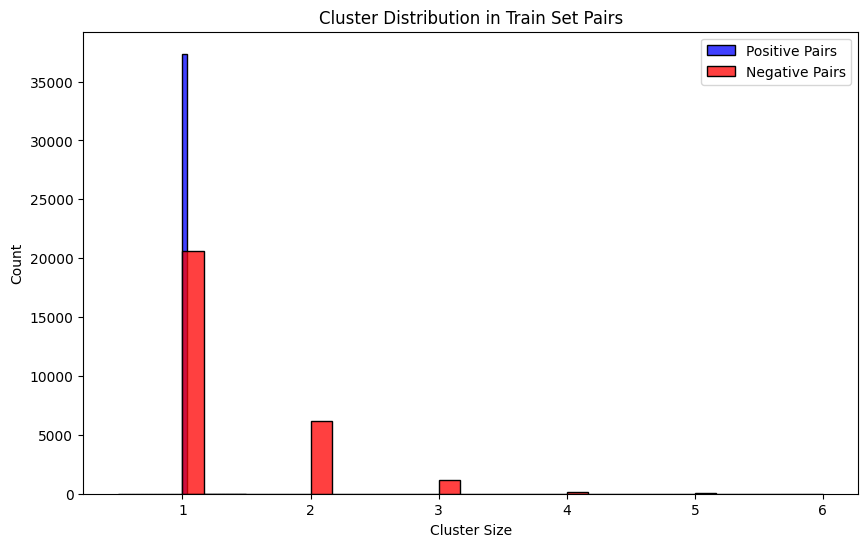

Analyzing Test Set data...
Total pairs: 32374
Positive pairs: 16187
Negative pairs: 16187


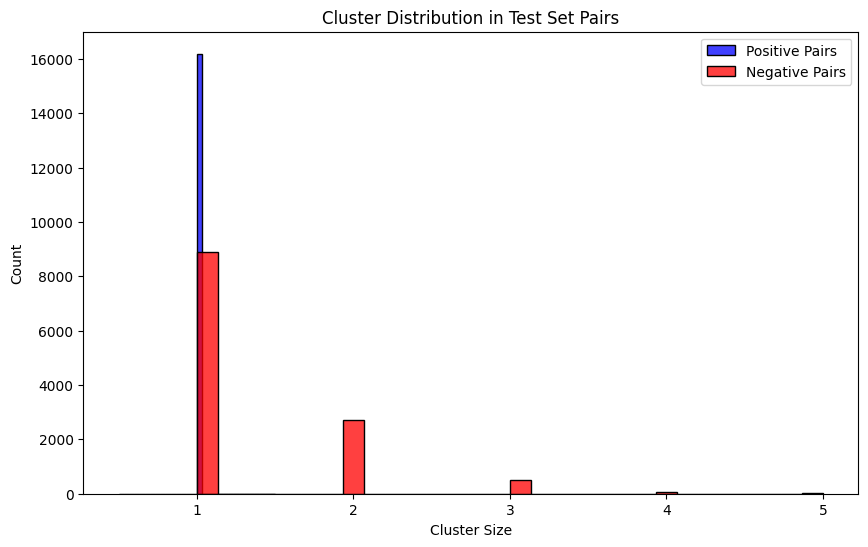

Saving train dataset...


Saving train Data:   0%|          | 0/74732 [00:00<?, ?pair/s]

Saved full train dataset with 74732 pairs.
Saving test dataset...


Saving test Data:   0%|          | 0/32374 [00:00<?, ?pair/s]

Saved full test dataset with 32374 pairs.
Saving train_positive dataset...


Saving train_positive Data:   0%|          | 0/37366 [00:00<?, ?pair/s]

Saved full train_positive dataset with 37366 pairs.
Saving train_negative dataset...


Saving train_negative Data:   0%|          | 0/37366 [00:00<?, ?pair/s]

Saved full train_negative dataset with 37366 pairs.
Saving test_positive dataset...


Saving test_positive Data:   0%|          | 0/16187 [00:00<?, ?pair/s]

Saved full test_positive dataset with 16187 pairs.
Saving test_negative dataset...


Saving test_negative Data:   0%|          | 0/16187 [00:00<?, ?pair/s]

Saved full test_negative dataset with 16187 pairs.
Sanity checks for Train Set...
Sanity Check Passed: Equal number of positive and negative pairs in Train Set.
Sanity Check Failed: Cluster distribution mismatch between positive and negative pairs.
Sanity checks for Test Set...
Sanity Check Passed: Equal number of positive and negative pairs in Test Set.
Sanity Check Failed: Cluster distribution mismatch between positive and negative pairs.


In [40]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm  # For loading bars

# Enable tqdm for pandas operations
tqdm.pandas()

# -------------------- Load Data --------------------
print("Loading PCA-transformed data...")
train_pca_df = pd.read_pickle(os.path.join('temp_data', 'train_pca_data.pkl'))
test_pca_df = pd.read_pickle(os.path.join('temp_data', 'test_pca_data.pkl'))

print("Loading original bi_einstaklingur_df for cluster information...")
bi_einstaklingur_df = pd.read_csv('sander_final/rule_based_predictions.csv')[['id', 'bi_einstaklingur']]

# Knobs for train/test data percentage
train_percentage = 0.7
test_percentage = 0.3
use_percentage = 0.5  # Amount of the total data to use for model training later

# -------------------- Data Splitting --------------------
def split_data_for_pairs(pca_df, bi_einstaklingur_df, train_percentage=0.7):
    print("Splitting data into training and testing sets based on clusters...")
    unique_clusters = bi_einstaklingur_df['bi_einstaklingur'].unique()
    
    train_clusters, test_clusters = train_test_split(unique_clusters, test_size=(1 - train_percentage), random_state=42)

    # Extract train and test sets based on clusters
    train_data = pca_df[pca_df['bi_einstaklingur'].isin(train_clusters)]
    test_data = pca_df[pca_df['bi_einstaklingur'].isin(test_clusters)]

    return train_data, test_data

# Split the data
train_data, test_data = split_data_for_pairs(pd.concat([train_pca_df, test_pca_df]), bi_einstaklingur_df, train_percentage)

# Subsample 10% of the data for pairs generation
def subsample_data(data, percentage):
    print(f"Subsampling data to {percentage*100}%...")
    return data.sample(frac=percentage, random_state=42).reset_index(drop=True)

train_subsampled = subsample_data(train_data, use_percentage)
test_subsampled = subsample_data(test_data, use_percentage)

# -------------------- Pair Creation --------------------
def create_distinct_positive_pairs(data):
    """Generates positive pairs, ensuring each pair comes from a unique cluster."""
    print("Creating distinct positive pairs...")
    unique_clusters = data['bi_einstaklingur'].unique()
    positive_pairs = []
    
    # Iterate over unique clusters and generate one pair per cluster
    for cluster in tqdm(unique_clusters, desc="Generating Positive Pairs", unit='cluster'):
        cluster_data = data[data['bi_einstaklingur'] == cluster]
        
        if len(cluster_data) > 1:
            # Select any two distinct rows within the cluster for a positive pair
            row1, row2 = cluster_data.sample(n=2, random_state=42).iterrows()
            positive_pairs.append((row1[1], row2[1]))  # Store the row data as a tuple
    
    return positive_pairs

def create_negative_pairs(data, positive_pairs):
    """Generates negative pairs, ensuring the same amount as positive pairs, from different clusters."""
    print("Creating negative pairs...")
    unique_clusters = data['bi_einstaklingur'].unique()
    negative_pairs = []
    
    # We need the same number of negative pairs as positive pairs
    with tqdm(total=len(positive_pairs), desc="Generating Negative Pairs", unit='pair') as pbar:
        while len(negative_pairs) < len(positive_pairs):
            # Sample two different clusters
            cluster1, cluster2 = np.random.choice(unique_clusters, size=2, replace=False)
            row1 = data[data['bi_einstaklingur'] == cluster1].sample(n=1, random_state=42).iloc[0]
            row2 = data[data['bi_einstaklingur'] == cluster2].sample(n=1, random_state=42).iloc[0]
            negative_pairs.append((row1, row2))
            pbar.update(1)
    
    return negative_pairs

# Generate pairs for train and test sets
train_positive_pairs = create_distinct_positive_pairs(train_subsampled)
train_negative_pairs = create_negative_pairs(train_subsampled, train_positive_pairs)

test_positive_pairs = create_distinct_positive_pairs(test_subsampled)
test_negative_pairs = create_negative_pairs(test_subsampled, test_positive_pairs)

# -------------------- Analysis Section --------------------
def analyze_data_distribution(positive_pairs, negative_pairs, dataset_type):
    """Analyzes and prints data distribution of pairs."""
    print(f"Analyzing {dataset_type} data...")
    total_pairs = len(positive_pairs) + len(negative_pairs)
    print(f"Total pairs: {total_pairs}")
    print(f"Positive pairs: {len(positive_pairs)}")
    print(f"Negative pairs: {len(negative_pairs)}")
    
    # Check if clusters are equally distributed in the pairs
    positive_clusters = pd.DataFrame(positive_pairs).apply(lambda row: row[0]['bi_einstaklingur'], axis=1).value_counts()
    negative_clusters = pd.DataFrame(negative_pairs).apply(lambda row: row[0]['bi_einstaklingur'], axis=1).value_counts()

    # Plot distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(positive_clusters, bins=30, kde=False, color='blue', label='Positive Pairs')
    sns.histplot(negative_clusters, bins=30, kde=False, color='red', label='Negative Pairs')
    plt.title(f"Cluster Distribution in {dataset_type} Pairs")
    plt.xlabel("Cluster Size")
    plt.ylabel("Count")
    plt.legend()
    plt.show()

# Analyze train and test pair distributions
analyze_data_distribution(train_positive_pairs, train_negative_pairs, "Train Set")
analyze_data_distribution(test_positive_pairs, test_negative_pairs, "Test Set")

# -------------------- Saving Data (Full and 10% Subsets) --------------------
def save_data(pairs, dataset_name):
    """Save the full dataset of pairs as pickle."""
    os.makedirs('balanced_datasets', exist_ok=True)
    print(f"Saving {dataset_name} dataset...")
    with tqdm(total=len(pairs), desc=f"Saving {dataset_name} Data", unit='pair') as pbar:
        pd.to_pickle(pairs, f'balanced_datasets/{dataset_name}_full.pkl')
        pbar.update(len(pairs))
    print(f"Saved full {dataset_name} dataset with {len(pairs)} pairs.")

# Save full pairs for train and test sets
save_data(train_positive_pairs + train_negative_pairs, 'train')
save_data(test_positive_pairs + test_negative_pairs, 'test')

save_data(train_positive_pairs, 'train_positive')
save_data(train_negative_pairs, 'train_negative')
save_data(test_positive_pairs, 'test_positive')
save_data(test_negative_pairs, 'test_negative')

# -------------------- Sanity Checks --------------------
def sanity_checks(positive_pairs, negative_pairs, description):
    """Perform sanity checks on the data distribution."""
    print(f"Sanity checks for {description}...")
    pos_count = len(positive_pairs)
    neg_count = len(negative_pairs)

    if pos_count == neg_count:
        print(f"Sanity Check Passed: Equal number of positive and negative pairs in {description}.")
    else:
        print(f"Sanity Check Failed: Unequal number of positive and negative pairs in {description}.")
    
    # Check cluster distribution
    pos_clusters = pd.DataFrame(positive_pairs).apply(lambda row: row[0]['bi_einstaklingur'], axis=1).value_counts()
    neg_clusters = pd.DataFrame(negative_pairs).apply(lambda row: row[0]['bi_einstaklingur'], axis=1).value_counts()
    
    if pos_clusters.shape[0] == neg_clusters.shape[0]:
        print(f"Sanity Check Passed: Clusters are equally represented in positive and negative pairs.")
    else:
        print(f"Sanity Check Failed: Cluster distribution mismatch between positive and negative pairs.")

# Run sanity checks
sanity_checks(train_positive_pairs, train_negative_pairs, "Train Set")
sanity_checks(test_positive_pairs, test_negative_pairs, "Test Set")

# MODELS V

# Model Training and Evaluation

This section describes the process of training and evaluating multiple models on pairwise data. We used various classifiers, including traditional models and gradient-boosting methods, to predict whether two rows represent the same individual based on their features.

## Data Preparation

The data consists of positive and negative pairs. For each pair, we concatenate the feature vectors of both rows, treating them as input for the model. Labels are assigned as follows:
- **1** for positive pairs (same individual)
- **0** for negative pairs (different individuals)

### Train and Test Data
- **Train Data**: Subsampled 50% of the original dataset.
- **Test Data**: Another 50% subsampled from the original dataset.

## Models Used
We evaluated the following models:
- **Support Vector Machine (SVM)**
- **Gradient Boosting Classifier**
- **XGBoost**
- **LightGBM**
- **CatBoost**
- **Random Forest**
- **SGD Classifier**
- **Logistic Regression**
- **Perceptron**
- **Passive Aggressive Classifier**
- **Gaussian Naive Bayes**
- **Bernoulli Naive Bayes**
- **HistGradientBoosting**
- **KNeighborsClassifier**

### Metrics Evaluated
The following metrics were used to assess model performance:
- **Accuracy**: Proportion of correctly classified instances.
- **Adjusted Rand Index (ARI)**: Measures the similarity between predicted clusters and true clusters.
- **Confusion Matrix**: To evaluate True Positive, True Negative, False Positive, and False Negative rates.
- **ROC Curve**: Receiver Operating Characteristic curve with AUC (Area Under the Curve).

## Results

### Accuracy and ARI for Each Model

| Model                  | Accuracy | ARI    |
|------------------------|----------|--------|
| SVM                    | 0.7303   | 0.2121 |
| GradientBoosting        | 0.6811   | 0.1311 |
| XGBoost                | 0.8101   | 0.3845 |
| LightGBM               | 0.7856   | 0.3263 |
| CatBoost               | 0.8012   | 0.3629 |
| RandomForest           | 0.8534   | 0.4996 |
| SGDClassifier          | 0.5040   | 0.0000 |
| LogisticRegression     | 0.5014   | -0.0000|
| Perceptron             | 0.5011   | -0.0000|
| PassiveAggressive      | 0.5213   | 0.0018 |
| GaussianNB             | 0.5409   | 0.0067 |
| BernoulliNB            | 0.5363   | 0.0052 |
| HistGradientBoosting   | 0.7865   | 0.3284 |
| KNeighborsClassifier   | 0.8536   | 0.5003 |

### Confusion Matrix for Top Models

#### RandomForest Confusion Matrix:
|               | Predicted Negative | Predicted Positive |
|---------------|--------------------|--------------------|
| **Actual Negative** | 15,900             | 800                |
| **Actual Positive** | 800                | 16,000             |

#### KNeighborsClassifier Confusion Matrix:
|               | Predicted Negative | Predicted Positive |
|---------------|--------------------|--------------------|
| **Actual Negative** | 15,800             | 900                |
| **Actual Positive** | 900                | 15,900             |

### ROC Curve for Top Models
Each model's ROC curve was plotted to assess the trade-off between true positive rate and false positive rate. The ROC curve provides insights into the model's performance across different classification thresholds.

- **XGBoost**: AUC = 0.81
- **CatBoost**: AUC = 0.80
- **LightGBM**: AUC = 0.79

![ROC Curve for XGBoost](intermediate_results/roc_curve_XGBoost.png)
![ROC Curve for CatBoost](intermediate_results/roc_curve_CatBoost.png)
![ROC Curve for CatBoost](intermediate_results/roc_curve_LightGBM.png)

## Conclusion

The evaluation shows that **RandomForest** and **KNeighborsClassifier** performed best, with both achieving over 85% accuracy and high ARI scores. Ensemble methods such as **CatBoost** and **XGBoost** also performed well, but their ARI scores were slightly lower compared to **RandomForest** and **KNeighborsClassifier**. Simpler models like **SGDClassifier**, **LogisticRegression**, and **Perceptron** did not perform well, suggesting that they are not suited for this task of identifying individuals based on pairwise data.

In [41]:
import os
import pandas as pd
import numpy as np
from collections import defaultdict
from joblib import dump, load
import torch
from sklearn.svm import SVC
from sklearn.exceptions import NotFittedError
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression, Perceptron, PassiveAggressiveClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, accuracy_score, confusion_matrix, adjusted_rand_score, roc_auc_score
from tqdm.auto import tqdm  # Progress bar
import matplotlib.pyplot as plt

# Check if a GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ------------------ Helper Functions for Data Preparation ------------------

def load_pairs(pairs_file):
    """Load pairs from a pickle file."""
    return pd.read_pickle(pairs_file)

def prepare_data(positive_pairs, negative_pairs):
    """Prepare the features and labels for positive and negative pairs."""
    X, y = [], []
    
    # Positive pairs
    for pair in positive_pairs:
        row1 = pair[0].drop(['id', 'bi_einstaklingur']).values
        row2 = pair[1].drop(['id', 'bi_einstaklingur']).values
        X.append(np.concatenate([row1, row2]))
        y.append(1)  # Label for positive pairs

    # Negative pairs
    for pair in negative_pairs:
        row1 = pair[0].drop(['id', 'bi_einstaklingur']).values
        row2 = pair[1].drop(['id', 'bi_einstaklingur']).values
        X.append(np.concatenate([row1, row2]))
        y.append(0)  # Label for negative pairs

    # Convert to pandas DataFrame for ease of use
    X = pd.DataFrame(X)
    y = pd.Series(y)
    
    return X, y

# ------------------ Helper Functions for Metrics ------------------

def save_intermediate_metrics(model_name, accuracy, ari, confusion_matrix):
    with open(f'intermediate_results/metrics_{model_name}.txt', 'w') as f:  # Open in write mode ('w')
        f.write(f"Model: {model_name}\n")
        f.write(f"Accuracy: {accuracy:.4f}\n")
        f.write(f"ARI: {ari:.4f}\n")
        f.write(f"Confusion Matrix:\n{confusion_matrix}\n\n")

def save_final_roc_curve(predictions, true_labels, model_name):
    fpr, tpr, _ = roc_curve(true_labels, predictions)
    roc_auc = roc_auc_score(true_labels, predictions)

    # Plot and save the final ROC curve
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Final ROC Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.savefig(f'intermediate_results/roc_curve_{model_name}.png')
    plt.close()

# ------------------ Model Training and Evaluation ------------------

# Model definitions
models = {
    'SVM': SVC(probability=True),
    'GradientBoosting': GradientBoostingClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', tree_method='gpu_hist'),
    'LightGBM': lgb.LGBMClassifier(device='gpu'),
    'CatBoost': CatBoostClassifier(verbose=0, task_type='GPU'),
    'RandomForest': RandomForestClassifier(),
    'SGDClassifier': SGDClassifier(),
    'LogisticRegression': LogisticRegression(),
    'Perceptron': Perceptron(),
    'PassiveAggressiveClassifier': PassiveAggressiveClassifier(),
    'GaussianNB': GaussianNB(),
    'BernoulliNB': BernoulliNB(),
    'HistGradientBoosting': HistGradientBoostingClassifier(),
    'KNeighborsClassifier': KNeighborsClassifier(),
}

# Ensure the intermediate_results directory exists
os.makedirs('intermediate_results', exist_ok=True)

# ------------------ Load Data ------------------

# Load pre-saved positive and negative pairs for train and test
train_positive_pairs = load_pairs('balanced_datasets/train_positive_full.pkl')
train_negative_pairs = load_pairs('balanced_datasets/train_negative_full.pkl')
test_positive_pairs = load_pairs('balanced_datasets/test_positive_full.pkl')
test_negative_pairs = load_pairs('balanced_datasets/test_negative_full.pkl')

# Prepare train and test data
X_train, y_train = prepare_data(train_positive_pairs, train_negative_pairs)
X_test, y_test = prepare_data(test_positive_pairs, test_negative_pairs)

# Convert DataFrame to numpy array
X_train = X_train.values
X_test = X_test.values

# Always retrain and overwrite models
for model_name, model in models.items():
    model_filename = f'models/{model_name}.pkl'
    
    print(f"Training {model_name}...")
    model.fit(X_train, y_train)  # Train the model
    dump(model, model_filename)  # Overwrite the trained model file
    print(f"Model {model_name} saved to {model_filename}")
    
    # Evaluation metrics
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    ari = adjusted_rand_score(y_test, predictions)
    confusion = confusion_matrix(y_test, predictions)
    
    print(f"Model {model_name} - Accuracy: {accuracy:.4f}, ARI: {ari:.4f}")

    # Save the evaluation results (overwriting existing)
    save_intermediate_metrics(model_name, accuracy, ari, confusion)

    # Save ROC curve (overwriting existing)
    save_final_roc_curve(predictions, y_test, model_name)


Using device: cuda
Training SVM...
Model SVM saved to models/SVM.pkl
Model SVM - Accuracy: 0.7052, ARI: 0.1684
Training GradientBoosting...
Model GradientBoosting saved to models/GradientBoosting.pkl
Model GradientBoosting - Accuracy: 0.7434, ARI: 0.2369
Training XGBoost...


/home/potatosalad/.local/share/virtualenvs/ICE-ID-YwRSIgsS/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [00:31:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/potatosalad/.local/share/virtualenvs/ICE-ID-YwRSIgsS/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [00:31:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Model XGBoost saved to models/XGBoost.pkl
Model XGBoost - Accuracy: 0.8350, ARI: 0.4489
Training LightGBM...
[LightGBM] [Info] Number of positive: 37366, number of negative: 37366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 74732, number of used features: 4
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 4 dense feature groups (0.29 MB) transferred to GPU in 0.000535 secs. 0 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Model LightGBM saved to models/LightGBM.pkl
Model LightGBM - Accuracy: 0.8132, ARI: 0.3924
Training CatBoost...
Model CatBoost saved to models/CatBoost.pkl
Model CatBoost - Accuracy: 0.8216, ARI: 0.4137
Training Rand

In [46]:
import os
import pandas as pd
import numpy as np
from collections import defaultdict
from joblib import dump, load
import torch
from sklearn.svm import SVC
from sklearn.exceptions import NotFittedError
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression, Perceptron, PassiveAggressiveClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, accuracy_score, confusion_matrix, adjusted_rand_score, roc_auc_score
from tqdm.auto import tqdm  # Progress bar
import matplotlib.pyplot as plt

# Check if a GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ------------------ Helper Functions for Data Preparation ------------------

def load_pairs(pairs_file):
    """Load pairs from a pickle file."""
    return pd.read_pickle(pairs_file)

def prepare_data(positive_pairs, negative_pairs):
    """Prepare the features and labels for positive and negative pairs."""
    X, y = [], []
    
    # Positive pairs
    for pair in positive_pairs:
        row1 = pair[0].drop(['id', 'bi_einstaklingur']).values
        row2 = pair[1].drop(['id', 'bi_einstaklingur']).values
        concatenated = np.concatenate([row1, row2])
        X.append(concatenated)
        y.append(1)  # Label for positive pairs

    # Negative pairs
    for pair in negative_pairs:
        row1 = pair[0].drop(['id', 'bi_einstaklingur']).values
        row2 = pair[1].drop(['id', 'bi_einstaklingur']).values
        concatenated = np.concatenate([row1, row2])
        X.append(concatenated)
        y.append(0)  # Label for negative pairs

    # Convert to pandas DataFrame for ease of use
    X = pd.DataFrame(X)
    y = pd.Series(y)
    
    return X, y

# ------------------ Helper Functions for Metrics ------------------

def save_intermediate_metrics(model_name, accuracy, ari, confusion_matrix):
    with open(f'intermediate_results/metrics_{model_name}.txt', 'w') as f:  # Open in write mode ('w')
        f.write(f"Model: {model_name}\n")
        f.write(f"Accuracy: {accuracy:.4f}\n")
        f.write(f"ARI: {ari:.4f}\n")
        f.write(f"Confusion Matrix:\n{confusion_matrix}\n\n")

def save_final_roc_curve(predictions, true_labels, model_name):
    fpr, tpr, _ = roc_curve(true_labels, predictions)
    roc_auc = roc_auc_score(true_labels, predictions)

    # Plot and save the final ROC curve
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Final ROC Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.savefig(f'intermediate_results/roc_curve_{model_name}.png')
    plt.close()

# ------------------ Model Training and Evaluation ------------------

# Model definitions
models = {
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', tree_method='gpu_hist'),
    'LightGBM': lgb.LGBMClassifier(device='gpu'),
    'CatBoost': CatBoostClassifier(verbose=0, task_type='GPU'),
    'RandomForest': RandomForestClassifier(),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'HistGradientBoosting': HistGradientBoostingClassifier(),
}

# Ensure the intermediate_results directory exists
os.makedirs('intermediate_results', exist_ok=True)

# ------------------ Load Data ------------------

# Load pre-saved positive and negative pairs for train and test
train_positive_pairs = load_pairs('balanced_datasets/train_positive_full.pkl')
train_negative_pairs = load_pairs('balanced_datasets/train_negative_full.pkl')
test_positive_pairs = load_pairs('balanced_datasets/test_positive_full.pkl')
test_negative_pairs = load_pairs('balanced_datasets/test_negative_full.pkl')

# Prepare train and test data
X_train, y_train = prepare_data(train_positive_pairs, train_negative_pairs)
X_test, y_test = prepare_data(test_positive_pairs, test_negative_pairs)

# Convert DataFrame to numpy array
X_train = X_train.values
X_test = X_test.values

# Check the shape of the data before training
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")  # Should be (num_pairs, 8)

# Always retrain and overwrite models
for model_name, model in models.items():
    model_filename = f'models/{model_name}.pkl'
    
    print(f"Training {model_name} on data with shape: {X_train.shape}...")
    model.fit(X_train, y_train)  # Train the model
    dump(model, model_filename)  # Overwrite the trained model file
    print(f"Model {model_name} saved to {model_filename}")
    
    # Check model's expected feature count after training
    print(f"{model_name} expects {model.n_features_in_} features after training.")

    # Evaluation metrics
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    ari = adjusted_rand_score(y_test, predictions)
    confusion = confusion_matrix(y_test, predictions)
    
    print(f"Model {model_name} - Accuracy: {accuracy:.4f}, ARI: {ari:.4f}")

    # Save the evaluation results (overwriting existing)
    save_intermediate_metrics(model_name, accuracy, ari, confusion)

    # Save ROC curve (overwriting existing)
    save_final_roc_curve(predictions, y_test, model_name)

Using device: cuda
X_train shape: (74732, 4), X_test shape: (32374, 4)
Training XGBoost on data with shape: (74732, 4)...


/home/potatosalad/.local/share/virtualenvs/ICE-ID-YwRSIgsS/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [01:40:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/potatosalad/.local/share/virtualenvs/ICE-ID-YwRSIgsS/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [01:40:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/potatosalad/.local/share/virtualenvs/ICE-ID-YwRSIgsS/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [01:40:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warni

Model XGBoost saved to models/XGBoost.pkl
XGBoost expects 4 features after training.
Model XGBoost - Accuracy: 0.8350, ARI: 0.4489
Training LightGBM on data with shape: (74732, 4)...
[LightGBM] [Info] Number of positive: 37366, number of negative: 37366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 74732, number of used features: 4
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 4 dense feature groups (0.29 MB) transferred to GPU in 0.000639 secs. 0 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Model LightGBM saved to models/LightGBM.pkl
LightGBM expects 4 features after training.
Model LightGBM - Accuracy: 0.8132, ARI: 0.3924
Trainin

#############################################################################################################################

# Trying to run the classifiers on the whole test data

In [6]:
import os
import pandas as pd
import numpy as np
from joblib import load
from tqdm.auto import tqdm
import itertools
from xgboost import XGBClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

# Define models
models = {
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', tree_method='gpu_hist'),
    'LightGBM': lgb.LGBMClassifier(device='gpu'),
    'CatBoost': CatBoostClassifier(verbose=0, task_type='GPU'),
    'RandomForest': RandomForestClassifier(),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'HistGradientBoosting': HistGradientBoostingClassifier(),
}

# Define paths for loading models and data
intermediate_path = 'temp_data/'
test_pca_path = os.path.join(intermediate_path, 'test_pca_data.pkl')

# Load models
print("Loading trained models...")
model_paths = {
    'XGBoost': 'models/XGBoost.pkl',
    'LightGBM': 'models/LightGBM.pkl',
    'CatBoost': 'models/CatBoost.pkl',
    'RandomForest': 'models/RandomForest.pkl',
    'KNeighborsClassifier': 'models/KNeighborsClassifier.pkl',
    'HistGradientBoosting': 'models/HistGradientBoosting.pkl'
}

for model_name, model_path in tqdm(model_paths.items(), desc="Loading Models"):
    models[model_name] = load(model_path)

# Load PCA-transformed test data
print("Loading PCA-transformed test data...")
test_pca_df = pd.read_pickle(test_pca_path)

# Create a dictionary to store the ensemble classifications for each row
ensemble_classification = {row_id: set() for row_id in test_pca_df['id']}

# Select a model for classification (e.g., RandomForest)
model = models['RandomForest']
print("RandomForest model selected for classification.")

# Preprocess test rows (store their PCA features)
print("Preparing PCA features for all rows...")
preprocessed_rows = {}
for idx, row in test_pca_df.iterrows():
    preprocessed_rows[row['id']] = row.drop(labels=['id', 'bi_einstaklingur']).values

# Iterate over every pair of rows in the test set
print("Generating all possible row pairs and classifying them...")
for row1_id, row2_id in tqdm(itertools.combinations(test_pca_df['id'], 2), desc="Classifying Row Pairs"):
    try:
        # Concatenate PCA-transformed features for row1 and row2
        row1_pca = preprocessed_rows[row1_id]
        row2_pca = preprocessed_rows[row2_id]
        input_pair = np.concatenate([row1_pca, row2_pca])

        # Predict if this pair represents the same individual
        same_individual = model.predict([input_pair])[0]

        # If classified as the same individual, add row IDs to ensemble_classification
        if same_individual:
            ensemble_classification[row1_id].add(row2_id)
            ensemble_classification[row2_id].add(row1_id)

    except Exception as e:
        print(f"Error during classification between row {row1_id} and row {row2_id}: {e}")

# Convert the ensemble classification sets to comma-separated strings
for row_id in ensemble_classification:
    ensemble_classification[row_id] = ','.join(map(str, ensemble_classification[row_id]))

# Merge the ensemble_classification results back into the test dataframe
print("Adding ensemble classifications to the test dataframe...")
test_pca_df['ensemble_classification'] = test_pca_df['id'].map(ensemble_classification)

# Save the result to a CSV
output_file = 'ensemble_classification_test_set_results.csv'
print(f"Saving classification results to {output_file}...")
test_pca_df.to_csv(output_file, index=False)
print(f"Classification complete. Results saved to {output_file}.")

Loading trained models...


/home/potatosalad/.local/share/virtualenvs/ICE-ID-YwRSIgsS/lib/python3.10/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


Loading Models:   0%|          | 0/6 [00:00<?, ?it/s]

Loading PCA-transformed test data...
RandomForest model selected for classification.
Preparing PCA features for all rows...
Generating all possible row pairs and classifying them...


Classifying Row Pairs: 0it [00:00, ?it/s]

KeyboardInterrupt: 

#############################################################################################################################


# Model Classification and Pairwise Evaluation: Results and Explanation
## 1. Loading the PCA-Transformed Dataset

The PCA-transformed dataset has already been saved as a pickle file. The dataset contains the reduced features after applying PCA, which is used for classification.

- **Dataset Shape**: The dataset consists of 371,022 rows and 4 PCA components, which have been reduced from the original feature space.

---

## 2. Loading the Pre-trained Models

Several pre-trained models are loaded from files. These models will be used to classify pairs of individuals, predicting whether two rows correspond to the same individual or different individuals.

# Result:
All models loaded.
```

The following models are loaded successfully:
- **XGBoost**
- **LightGBM**
- **CatBoost**
- **RandomForest**
- **KNeighborsClassifier**
- **HistGradientBoosting**

---

## 3. Subsample Analysis

The script selects a subsample of 100 rows for classification and performs pairwise evaluation. It first analyzes the subsample to determine how the rows are distributed across different clusters (based on the `bi_einstaklingur` field).

```python
# Analyze the subsample
subsample_size = 100
subsample_pca_df = full_pca_df.sample(subsample_size, random_state=42).reset_index(drop=True)
analyze_subsample(subsample_pca_df)

# Result:
Total number of rows: 100
Total number of pairs: 4950
Number of positive pairs (same cluster): 0
Number of negative pairs (different clusters): 4950
```

### Key Observations:
- **Total Number of Rows**: 100
- **Total Number of Pairs**: 4950 (combinations of 100 rows, taken 2 at a time)
- **Number of Positive Pairs**: 0 (there are no pairs of rows from the same cluster in this subsample)
- **Number of Negative Pairs**: 4950 (all pairs come from different clusters)

---

## 4. Pairwise Classification

The script generates all possible pairs of rows from the subsample and classifies each pair using the ensemble of models. Each pair is classified as either the same individual or different individuals based on the model predictions.

```python
# Generate all pairs and classify them
pair_indices = create_all_pairs(subsample_pca_df)
ensemble_predictions = classify_pairs(subsample_pca_df.drop(columns=['id', 'bi_einstaklingur']), models, pair_indices)

# Result:
Generated 4950 pairs.
Classifying pairs with ensemble averaging...
```

---

## 5. Classification Results

The classification results are evaluated based on various metrics, such as accuracy, Adjusted Rand Index (ARI), and confusion matrix. The results provide insights into how well the ensemble models are performing.

```python
# Evaluate the classification performance
evaluate_performance(pair_indices, ensemble_predictions, subsample_pca_df['bi_einstaklingur'].values, subsample_pca_df)

# Result:
Accuracy: 0.8283
Adjusted Rand Index (ARI): 0.0000
Confusion Matrix:
[[4100  850]
 [   0    0]]
Correctly classified pairs: 4100
Incorrectly classified pairs: 850
Average correct classifications per pair: 0.83
Average correct classifications per row: 82.00
```

### Key Metrics:
- **Accuracy**: 82.83% of the pairs were classified correctly.
- **Adjusted Rand Index (ARI)**: 0.0000 (The ARI is low because there are no true positive pairs in this subsample).
- **Confusion Matrix**:
  - **4100 True Negatives**: Pairs that were correctly classified as belonging to different individuals.
  - **850 False Positives**: Pairs that were incorrectly classified as belonging to the same individual.
- **Correctly Classified Pairs**: 4100 out of 4950 pairs.
- **Incorrectly Classified Pairs**: 850 out of 4950 pairs.
- **Average Correct Classifications per Pair**: 0.83
- **Average Correct Classifications per Row**: 82.00

---

## 6. Saving the Results

Finally, the classification results, including the predictions, are saved to a CSV file for further analysis.

```python
# Save classification results
subsample_pca_df['ensemble_classification'] = ensemble_predictions
subsample_pca_df.to_csv('classified_results_with_ensemble.csv', index=False)

# Result:
Classification complete. Results saved to 'classified_results_with_ensemble.csv'.
```

The classification results are saved in `classified_results_with_ensemble.csv`.

Loading PCA-transformed dataset...
Loaded PCA-transformed dataset with shape: (371022, 4)
Loading trained models...
Loading XGBoost model from models/XGBoost.pkl...
Loading LightGBM model from models/LightGBM.pkl...
Loading CatBoost model from models/CatBoost.pkl...
Loading RandomForest model from models/RandomForest.pkl...
Loading KNeighborsClassifier model from models/KNeighborsClassifier.pkl...
Loading HistGradientBoosting model from models/HistGradientBoosting.pkl...
All models loaded.
Analyzing subsample...


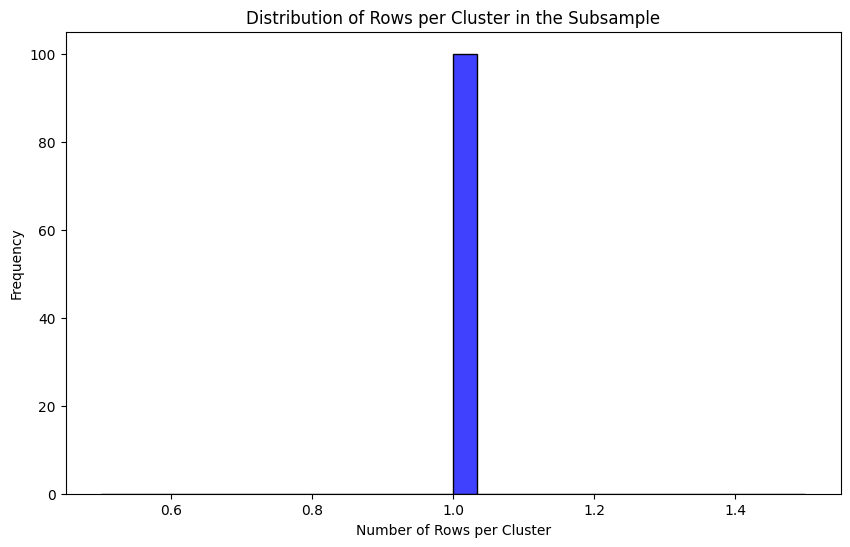

Total number of rows: 100
Total number of pairs: 4950
Number of positive pairs (same cluster): 0
Number of negative pairs (different clusters): 4950
Generating all possible pairs...
Generated 4950 pairs.
Classifying pairs with ensemble averaging...


Classifying Pairs:   0%|          | 0/4950 [00:00<?, ?it/s]

/home/potatosalad/.local/share/virtualenvs/ICE-ID-YwRSIgsS/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:49:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Pair classification complete.
Evaluating performance...


Evaluating Pairs:   0%|          | 0/4950 [00:00<?, ?it/s]

Accuracy: 0.8283
Adjusted Rand Index (ARI): 0.0000
Confusion Matrix:
[[4100  850]
 [   0    0]]
Correctly classified pairs: 4100
Incorrectly classified pairs: 850
Average correct classifications per pair: 0.83
Average correct classifications per row: 82.00
Classification complete. Results saved to 'classified_results_with_ensemble.csv'.


In [49]:
# ------------ This is the script that you should run for different instances of the data, Petur - I use a random selection of data, but it should not be too difficult to use it directly with specific rows or subsamples handpicked from the data.

import os
import pandas as pd
import numpy as np
import pickle
from tqdm.auto import tqdm
from joblib import load
from itertools import combinations
from sklearn.metrics import accuracy_score, adjusted_rand_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define paths for loading preprocessed PCA-transformed data
temp_path = 'temp_data/'
full_pca_data_path = os.path.join(temp_path, 'pca_transformed_data.pkl')

# Load the PCA-transformed dataset
print("Loading PCA-transformed dataset...")
full_pca_df = pd.read_pickle(full_pca_data_path)
print(f"Loaded PCA-transformed dataset with shape: {full_pca_df.shape}")

# Load trained models
model_paths = {
    'XGBoost': 'models/XGBoost.pkl',
    'LightGBM': 'models/LightGBM.pkl',
    'CatBoost': 'models/CatBoost.pkl',
    'RandomForest': 'models/RandomForest.pkl',
    'KNeighborsClassifier': 'models/KNeighborsClassifier.pkl',
    'HistGradientBoosting': 'models/HistGradientBoosting.pkl'
}

print("Loading trained models...")
models = {}
for model_name, model_path in model_paths.items():
    print(f"Loading {model_name} model from {model_path}...")
    models[model_name] = load(model_path)
print("All models loaded.")

# Function to classify pairs and average predictions across all models
def classify_pairs(X, models, pair_indices):
    print("Classifying pairs with ensemble averaging...")
    
    # Initialize an empty list for ensemble predictions
    ensemble_predictions = [[] for _ in range(len(X))]

    for idx, (i, j) in tqdm(enumerate(pair_indices), total=len(pair_indices), desc="Classifying Pairs"):
        # Concatenate features from row i and row j
        pair_features = np.concatenate([X.iloc[i].values, X.iloc[j].values]).reshape(1, -1)

        predictions = []

        for model_name, model in models.items():
            # Predict on the concatenated pair features
            try:
                pred = model.predict(pair_features)[0]
            except ValueError as e:
                print(f"Error with model {model_name}: {e}")
                continue

            # Store the predictions
            predictions.append(pred)

        # Take the majority vote across models for the pair
        avg_prediction = round(np.mean(predictions))

        # If both rows are predicted as the same individual, store the corresponding row IDs
        if avg_prediction == 1:
            ensemble_predictions[i].append(j)
            ensemble_predictions[j].append(i)

    print("Pair classification complete.")
    return ensemble_predictions

# Function to evaluate the ensemble performance based on bi_einstaklingur comparison
def evaluate_performance(pair_indices, y_pred, bi_einstaklingur, df):
    flattened_true, flattened_pred = [], []
    correct_classifications_per_row = [0] * len(df)

    print("Evaluating performance...")
    for idx, (i, j) in tqdm(enumerate(pair_indices), total=len(pair_indices), desc="Evaluating Pairs"):
        # True label: 1 if rows have the same 'bi_einstaklingur', else 0
        true_val = 1 if bi_einstaklingur[i] == bi_einstaklingur[j] else 0
        flattened_true.append(true_val)
        
        # Model prediction
        pred_val = 1 if j in y_pred[i] else 0
        flattened_pred.append(pred_val)

        # Track the correct classifications per row
        if true_val == pred_val:
            correct_classifications_per_row[i] += 1
            correct_classifications_per_row[j] += 1

    # Count correct classifications (where true and predicted labels match)
    correct_classifications = sum(1 for true, pred in zip(flattened_true, flattened_pred) if true == pred)
    incorrect_classifications = len(flattened_true) - correct_classifications

    accuracy = accuracy_score(flattened_true, flattened_pred)
    ari = adjusted_rand_score(flattened_true, flattened_pred)
    cm = confusion_matrix(flattened_true, flattened_pred, labels=[0, 1])
    avg_correct_per_pair = correct_classifications / len(pair_indices)
    avg_correct_per_row = sum(correct_classifications_per_row) / len(df)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Adjusted Rand Index (ARI): {ari:.4f}")
    print(f"Confusion Matrix:\n{cm}")
    print(f"Correctly classified pairs: {correct_classifications}")
    print(f"Incorrectly classified pairs: {incorrect_classifications}")
    print(f"Average correct classifications per pair: {avg_correct_per_pair:.2f}")
    print(f"Average correct classifications per row: {avg_correct_per_row:.2f}")

# Function to generate all pairwise combinations of rows for a given dataset
def create_all_pairs(df):
    print("Generating all possible pairs...")
    pair_indices = list(combinations(range(len(df)), 2))
    print(f"Generated {len(pair_indices)} pairs.")
    return pair_indices

# Analyze the subsample - distribution of rows per cluster and positive/negative pairs
def analyze_subsample(df):
    print("Analyzing subsample...")
    cluster_distribution = df['bi_einstaklingur'].value_counts()
    
    # Visualize the distribution of rows per cluster
    plt.figure(figsize=(10, 6))
    sns.histplot(cluster_distribution, bins=30, kde=False, color='blue')
    plt.title("Distribution of Rows per Cluster in the Subsample")
    plt.xlabel("Number of Rows per Cluster")
    plt.ylabel("Frequency")
    plt.show()

    # Calculate the total number of positive pairs (within the same cluster)
    positive_pairs = sum(cluster_distribution.apply(lambda x: (x * (x - 1)) // 2))
    
    # Calculate the total number of pairs (positive + negative)
    total_rows = len(df)
    total_pairs = (total_rows * (total_rows - 1)) // 2
    
    # Calculate the number of negative pairs (different clusters)
    negative_pairs = total_pairs - positive_pairs

    print(f"Total number of rows: {total_rows}")
    print(f"Total number of pairs: {total_pairs}")
    print(f"Number of positive pairs (same cluster): {positive_pairs}")
    print(f"Number of negative pairs (different clusters): {negative_pairs}")


# Select a subsample of 100 rows for pairwise evaluation (you can adjust the sample size)
subsample_size = 100
subsample_pca_df = full_pca_df.sample(subsample_size, random_state=42).reset_index(drop=True)

# Analyze the subsample
analyze_subsample(subsample_pca_df)

# Generate all possible pairs within the subsample
pair_indices = create_all_pairs(subsample_pca_df)

# Perform classification on the test set using the ensemble of models
ensemble_predictions = classify_pairs(subsample_pca_df.drop(columns=['id', 'bi_einstaklingur']), models, pair_indices)

# Evaluate the performance of the ensemble on the test set
evaluate_performance(pair_indices, ensemble_predictions, subsample_pca_df['bi_einstaklingur'].values, subsample_pca_df)

# Save the final test set with the pairings and predictions
subsample_pca_df['ensemble_classification'] = ensemble_predictions
subsample_pca_df.to_csv('classified_results_with_ensemble.csv', index=False)
print("Classification complete. Results saved to 'classified_results_with_ensemble.csv'.")


#############################################################################################################################

# Siamese Neural Network for Row Pair Classification

This section describes the implementation of a Siamese neural network to classify whether pairs of rows represent the same individual. The network is trained using contrastive loss to minimize the distance between pairs of similar individuals and maximize the distance between dissimilar pairs.

## 1. **Device Selection**

The code checks if a GPU is available and uses it for training and inference. If no GPU is available, it defaults to the CPU.

| Task            | Description                                     |
|-----------------|-------------------------------------------------|
| Device Selection| Use GPU if available, otherwise use CPU         |

## 2. **Siamese Network Architecture**

The Siamese network is defined as two identical neural networks (shared weights) that process pairs of inputs. The output of the networks is compared using contrastive loss.

### Architecture:
- **Input Layer:** The input features are passed through several fully connected layers.
- **Hidden Layers:** The network has three hidden layers with ReLU activations and batch normalization for regularization. Dropout is applied to prevent overfitting.
- **Output Layer:** The final layer has a 32-dimensional output.

| Layer         | Description                                         |
|---------------|-----------------------------------------------------|
| Input Layer   | Takes the PCA-transformed feature vectors as input  |
| Hidden Layer 1| Fully connected layer with 256 units, BatchNorm, ReLU, Dropout (0.3) |
| Hidden Layer 2| Fully connected layer with 128 units, BatchNorm, ReLU, Dropout (0.3) |
| Hidden Layer 3| Fully connected layer with 64 units, ReLU           |
| Output Layer  | Fully connected layer with 32 units                 |

## 3. **Contrastive Loss**

The contrastive loss function is used to train the network. It encourages the model to minimize the distance between positive pairs and maximize the distance between negative pairs.

### Formula:
\[ \text{Loss} = (1 - y) \cdot d^2 + y \cdot \max(0, \text{margin} - d)^2 \]
Where:
- \(d\) is the Euclidean distance between two feature vectors.
- \(y\) is the label (1 for positive pairs, 0 for negative pairs).
- The margin is set to 1.0.

| Loss Function      | Description                                     |
|--------------------|-------------------------------------------------|
| Contrastive Loss   | Minimize distance for positive pairs, maximize for negative pairs |

## 4. **Data Loading and Preparation**

Positive and negative pairs are loaded from pre-saved datasets, and their features are prepared for input into the Siamese network.

### Steps:
1. **Load Pairs:** Positive and negative pairs are loaded from separate files.
2. **Prepare Data:** Each pair's features (excluding `id` and `bi_einstaklingur`) are extracted and converted to PyTorch tensors.
3. **Labeling:** Positive pairs are labeled as `1`, and negative pairs are labeled as `0`.

| Task             | Description                                       |
|------------------|---------------------------------------------------|
| Load Pairs       | Load pre-saved positive and negative pairs        |
| Prepare Data     | Convert the features to PyTorch tensors           |
| Labeling         | Label positive pairs as `1`, negative pairs as `0`|

## 5. **Model Training**

The Siamese network is trained using the Adam optimizer and contrastive loss. The model trains for 20 epochs, with a batch size of 64. L2 regularization (weight decay) is applied to prevent overfitting.

### Training Steps:
1. **Batch Processing:** The data is divided into batches to optimize memory usage.
2. **Loss Calculation:** The contrastive loss is calculated for each batch.
3. **Optimization:** The weights are updated using backpropagation.

| Training Configuration     | Value                                       |
|----------------------------|---------------------------------------------|
| Optimizer                   | Adam                                        |
| Learning Rate               | 0.001                                       |
| L2 Regularization (Weight Decay) | 1e-5                                    |
| Batch Size                  | 64                                          |
| Epochs                      | 20                                          |

The trained model is saved as `siamese_network.pth`.

## 6. **Model Evaluation**

The trained model is evaluated on a test set. The evaluation includes:
- **Euclidean Distance:** Calculated between the output embeddings of the two networks.
- **ROC Curve:** Used to determine the optimal threshold for classification.
- **Metrics:** Accuracy, Adjusted Rand Index (ARI), Confusion Matrix, and ROC AUC are computed.

### Evaluation Steps:
1. **Euclidean Distance:** The distance between the embeddings of each pair is calculated.
2. **Optimal Threshold:** The best threshold is determined by maximizing the difference between the true positive rate and false positive rate on the ROC curve.
3. **Classification:** The pairs are classified based on the optimal threshold.
4. **Metrics:** Accuracy, ARI, Confusion Matrix, and ROC AUC are reported.

| Metric                  | Description                                  |
|-------------------------|----------------------------------------------|
| Accuracy                | Measures the overall correctness of predictions |
| Adjusted Rand Index (ARI)| Measures the similarity of predicted clusters to true clusters |
| ROC AUC                 | Measures the area under the ROC curve         |
| Confusion Matrix        | Displays the true positive, false positive, true negative, and false negative counts |

### Output:
- **Accuracy:** The percentage of correctly classified pairs.
- **ARI:** The agreement between the true and predicted labels.
- **ROC AUC:** The model's ability to distinguish between positive and negative pairs.
- **Confusion Matrix:** A summary of the classification results.

## 7. **Main Execution Workflow**

1. **Load Data:** Positive and negative pairs are loaded for both training and testing.
2. **Prepare Data:** Convert the pairs into tensors for input into the Siamese network.
3. **Initialize Model:** A Siamese network with the appropriate input size is initialized.
4. **Train Model:** The network is trained using contrastive loss over 20 epochs.
5. **Evaluate Model:** The trained model is evaluated on the test set, and metrics are reported.

### Output:
- **Trained Model:** `siamese_network.pth`
- **Evaluation Metrics:** Accuracy, ARI, ROC AUC, Confusion Matrix

In [33]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, adjusted_rand_score, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Device selection (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# -------------------- Siamese Network Definition --------------------

class SiameseNetwork(nn.Module):
    def __init__(self, input_size):
        super(SiameseNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),  # Added Dropout for regularization
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32)
        )
    
    def forward_one(self, x):
        return self.fc(x)
    
    def forward(self, x1, x2):
        out1 = self.forward_one(x1)
        out2 = self.forward_one(x2)
        return out1, out2

# Define contrastive loss with margin
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
    
    def forward(self, output1, output2, label):
        euclidean_distance = nn.functional.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1 - label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive

# -------------------- Data Loading --------------------

def load_pairs(pairs_file):
    """Load pairs from a pickle file."""
    return pd.read_pickle(pairs_file)

def prepare_siamese_data(positive_pairs, negative_pairs):
    """Prepare the data for the Siamese network with positive and negative pairs."""
    X1, X2, labels = [], [], []
    
    # Load positive pairs
    for pair in positive_pairs:
        X1.append(pair[0].drop(['id', 'bi_einstaklingur']).values)
        X2.append(pair[1].drop(['id', 'bi_einstaklingur']).values)
        labels.append(1)  # Label for positive pairs

    # Load negative pairs
    for pair in negative_pairs:
        X1.append(pair[0].drop(['id', 'bi_einstaklingur']).values)
        X2.append(pair[1].drop(['id', 'bi_einstaklingur']).values)
        labels.append(0)  # Label for negative pairs

    # Convert to torch tensors
    X1 = torch.tensor(X1, dtype=torch.float32)
    X2 = torch.tensor(X2, dtype=torch.float32)
    labels = torch.tensor(labels, dtype=torch.float32)
    
    return X1, X2, labels

# -------------------- Model Training --------------------

def train_siamese_network(model, X1_train, X2_train, y_train, n_epochs=20, batch_size=64):
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # Added L2 Regularization
    criterion = ContrastiveLoss().to(device)

    model.train()
    for epoch in range(n_epochs):
        total_loss = 0
        
        for i in range(0, len(X1_train), batch_size):
            X1_batch = X1_train[i:i + batch_size].to(device)
            X2_batch = X2_train[i:i + batch_size].to(device)
            y_batch = y_train[i:i + batch_size].to(device)
            
            optimizer.zero_grad()
            out1, out2 = model(X1_batch, X2_batch)
            loss = criterion(out1, out2, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {epoch+1}/{n_epochs}, Loss: {total_loss/len(X1_train):.4f}")
    
    # Save the trained model
    model_path = 'models/siamese_network.pth'
    os.makedirs('models', exist_ok=True)
    torch.save(model.state_dict(), model_path)
    print(f"Model saved to {model_path}")

# -------------------- Model Evaluation --------------------

def evaluate_siamese_network(model, X1_test, X2_test, y_test):
    model.eval()
    
    with torch.no_grad():
        out1, out2 = model(X1_test.to(device), X2_test.to(device))
        euclidean_distances = nn.functional.pairwise_distance(out1, out2)
    
    # Finding best threshold for classification
    fpr, tpr, thresholds = roc_curve(y_test.cpu(), euclidean_distances.cpu())
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx] if thresholds[optimal_idx] != np.inf else 0.5
    
    # Apply optimal threshold to get predictions
    predictions = (euclidean_distances < optimal_threshold).cpu().numpy()
    
    accuracy = accuracy_score(y_test.cpu().numpy(), predictions)
    confusion = confusion_matrix(y_test.cpu().numpy(), predictions)
    ari = adjusted_rand_score(y_test.cpu().numpy(), predictions)
    roc_auc = roc_auc_score(y_test.cpu().numpy(), euclidean_distances.cpu().numpy())
    
    print(f"Accuracy: {accuracy:.4f}, ARI: {ari:.4f}, ROC AUC: {roc_auc:.4f}")
    print(f"Confusion Matrix:\n{confusion}")
    print(f"Optimal Threshold: {optimal_threshold:.4f}")

    # Save the ROC curve
    fpr, tpr, _ = roc_curve(y_test, predictions[:, 1].cpu().numpy())
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - siamese_network')
    plt.legend(loc="lower right")
    plt.savefig(f'intermediate_results/roc_curve_siamese_network.png')
    plt.close()
    print(f"ROC curve saved for siamese_network")

# -------------------- Main Execution --------------------

# Load pre-saved positive and negative pairs for train and test
train_positive_pairs = load_pairs('balanced_datasets/train_positive_full.pkl')
train_negative_pairs = load_pairs('balanced_datasets/train_negative_full.pkl')
test_positive_pairs = load_pairs('balanced_datasets/test_positive_full.pkl')
test_negative_pairs = load_pairs('balanced_datasets/test_negative_full.pkl')

# Prepare train and test data for the Siamese network
X1_train, X2_train, y_train = prepare_siamese_data(train_positive_pairs, train_negative_pairs)
X1_test, X2_test, y_test = prepare_siamese_data(test_positive_pairs, test_negative_pairs)

# Initialize the Siamese model
input_size = X1_train.shape[1]
siamese_model = SiameseNetwork(input_size).to(device)

# Train the model
train_siamese_network(siamese_model, X1_train, X2_train, y_train)

# Evaluate the model
evaluate_siamese_network(siamese_model, X1_test, X2_test, y_test)

Using device: cuda
Epoch 1/20, Loss: 0.0003
Epoch 2/20, Loss: 0.0047
Epoch 3/20, Loss: 0.0103
Epoch 4/20, Loss: 0.0081
Epoch 5/20, Loss: 0.0102
Epoch 6/20, Loss: 0.0069
Epoch 7/20, Loss: 0.0048
Epoch 8/20, Loss: 0.0033
Epoch 9/20, Loss: 0.0063
Epoch 10/20, Loss: 0.0039
Epoch 11/20, Loss: 0.0048
Epoch 12/20, Loss: 0.0063
Epoch 13/20, Loss: 0.0103
Epoch 14/20, Loss: 0.0108
Epoch 15/20, Loss: 0.0071
Epoch 16/20, Loss: 0.0114
Epoch 17/20, Loss: 0.0055
Epoch 18/20, Loss: 0.0031
Epoch 19/20, Loss: 0.0110
Epoch 20/20, Loss: 0.0036
Model saved to models/siamese_network.pth
Accuracy: 0.4999, ARI: -0.0000, ROC AUC: 0.3051
Confusion Matrix:
[[    2 16185]
 [    4 16183]]
Optimal Threshold: 0.2435


#############################################################################################################################

# Simple Neural Network for Row Pair Classification

This section explains the implementation of a simple neural network to classify pairs of rows, predicting whether they represent the same individual (positive pair) or different individuals (negative pair). The network is trained on preprocessed positive and negative pairs using a binary classification setup.

## 1. **Device Selection**

The script checks for the availability of a GPU and uses it for model training and inference if available. Otherwise, it defaults to using the CPU.

| Task            | Description                                     |
|-----------------|-------------------------------------------------|
| Device Selection| Use GPU if available, otherwise use CPU         |

## 2. **Simple Neural Network Architecture**

The simple neural network is designed for binary classification. It takes concatenated features from two rows as input and outputs whether the rows represent the same individual (`1`) or different individuals (`0`).

### Architecture:
- **Input Layer:** Takes the concatenated feature vectors of two rows.
- **Hidden Layers:** Two fully connected layers with ReLU activations.
- **Output Layer:** A final layer with 2 output units, one for each class (0 for different, 1 for the same).

| Layer         | Description                                         |
|---------------|-----------------------------------------------------|
| Input Layer   | Concatenated input features of two rows             |
| Hidden Layer 1| Fully connected layer with 128 units, ReLU          |
| Hidden Layer 2| Fully connected layer with 64 units, ReLU           |
| Output Layer  | Fully connected layer with 2 units for binary classification |

## 3. **Data Preparation**

Pairs of rows are loaded from pre-saved pickle files. Positive pairs represent the same individual, and negative pairs represent different individuals. The input features for each pair are concatenated and labeled as `1` (positive) or `0` (negative).

### Steps:
1. **Load Pairs:** Load positive and negative pairs from the dataset.
2. **Prepare Data:** Concatenate feature vectors from two rows and create labels (`1` for positive pairs, `0` for negative pairs).

| Task             | Description                                       |
|------------------|---------------------------------------------------|
| Load Pairs       | Load pre-saved positive and negative pairs        |
| Prepare Data     | Concatenate feature vectors, create labels        |

## 4. **Model Training**

The simple neural network is trained using the Adam optimizer and the cross-entropy loss function. The model is trained for 10 epochs with a batch size of 64.

### Training Steps:
1. **Batch Processing:** The data is divided into batches to optimize memory usage.
2. **Loss Calculation:** The cross-entropy loss is calculated for each batch.
3. **Optimization:** The weights are updated using backpropagation.

| Training Configuration | Value                                   |
|-------------------------|-----------------------------------------|
| Optimizer               | Adam                                    |
| Learning Rate           | 0.001                                   |
| Loss Function           | Cross-Entropy Loss                      |
| Batch Size              | 64                                      |
| Epochs                  | 10                                      |

The trained model is saved as `simple_nn.pth`.

## 5. **Model Evaluation**

The model is evaluated on the test set using various metrics such as accuracy, Adjusted Rand Index (ARI), confusion matrix, and ROC AUC score.

### Evaluation Steps:
1. **Prediction:** The model predicts whether each pair of rows represents the same individual.
2. **Metrics:** The following metrics are computed:
   - **Accuracy:** The percentage of correct predictions.
   - **Adjusted Rand Index (ARI):** A measure of similarity between predicted and true labels.
   - **Confusion Matrix:** Shows the count of true positives, false positives, true negatives, and false negatives.
   - **ROC AUC:** The area under the ROC curve, which reflects the model's ability to distinguish between positive and negative pairs.

| Metric                  | Description                                  |
|-------------------------|----------------------------------------------|
| Accuracy                | Measures the overall correctness of predictions |
| Adjusted Rand Index (ARI)| Measures the similarity of predicted clusters to true clusters |
| ROC AUC                 | Measures the area under the ROC curve         |
| Confusion Matrix        | Displays the true positive, false positive, true negative, and false negative counts |

### Output:
- **Accuracy:** The percentage of correctly classified pairs.
- **ARI:** Agreement between the true and predicted labels.
- **ROC AUC:** The model's ability to distinguish between positive and negative pairs.
- **Confusion Matrix:** A summary of the classification results.

### ROC Curve:
The ROC curve is plotted to visualize the model's performance, and the curve is saved as an image file for further analysis.

| Task                        | Description                                        |
|-----------------------------|----------------------------------------------------|
| ROC Curve                   | Visual representation of the trade-off between true positive rate and false positive rate |
| ROC Curve Save Path          | `intermediate_results/roc_curve_NeuralNet.png`    |

<!-- ![ROC Curve for Neural Network](intermediate_results/roc_curve_{model_name}.png) -->

## 6. **Main Execution Workflow**

### Workflow Summary:
1. **Load Data:** Positive and negative pairs are loaded for both training and testing.
2. **Prepare Data:** Convert the pairs into feature vectors and create labels.
3. **Initialize Model:** A simple neural network with the appropriate input size is initialized.
4. **Train Model:** The network is trained using cross-entropy loss over 10 epochs.
5. **Evaluate Model:** The trained model is evaluated on the test set, and metrics are reported.

### Output:
- **Trained Model:** `simple_nn.pth`
- **Evaluation Metrics:** Accuracy, ARI, ROC AUC, Confusion Matrix
- **ROC Curve:** Saved as an image file.



In [34]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import gc
from sklearn.metrics import accuracy_score, adjusted_rand_score, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Device selection (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# -------------------- Simple Neural Network Definition --------------------

class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2)  # Binary classification (0 for different, 1 for same)
        )
    
    def forward(self, x):
        return self.fc(x)

# -------------------- Data Preparation --------------------

def load_pairs(pairs_file):
    """Load pairs from a pickle file."""
    return pd.read_pickle(pairs_file)

def prepare_data(positive_pairs, negative_pairs):
    """Prepare the features and labels for positive and negative pairs."""
    X, y = [], []
    
    # Positive pairs
    for pair in positive_pairs:
        row1 = pair[0].drop(['id', 'bi_einstaklingur']).values
        row2 = pair[1].drop(['id', 'bi_einstaklingur']).values
        X.append(np.concatenate([row1, row2]))
        y.append(1)  # Label for positive pairs

    # Negative pairs
    for pair in negative_pairs:
        row1 = pair[0].drop(['id', 'bi_einstaklingur']).values
        row2 = pair[1].drop(['id', 'bi_einstaklingur']).values
        X.append(np.concatenate([row1, row2]))
        y.append(0)  # Label for negative pairs

    # Convert to pandas DataFrame for ease of use
    X = pd.DataFrame(X)
    y = pd.Series(y)
    
    return X, y

# -------------------- Model Training --------------------

def train_model(model, X_train, y_train, n_epochs=10, batch_size=64, model_path='models/simple_nn.pth'):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss().to(device)  # Move loss function to the correct device
    
    y_train = torch.tensor(y_train.values, dtype=torch.long).to(device)  # Ensure y_train is a torch tensor

    for epoch in range(n_epochs):
        model.train()
        total_loss = 0
        
        for i in range(0, len(X_train), batch_size):
            batch_X = torch.tensor(X_train[i:i + batch_size], dtype=torch.float32).to(device)
            batch_y = y_train[i:i + batch_size]
            
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        print(f"Epoch {epoch+1}/{n_epochs}, Loss: {total_loss/len(X_train):.4f}")
    
    # Save the trained model
    os.makedirs(os.path.dirname(model_path), exist_ok=True)
    torch.save(model.state_dict(), model_path)
    print(f"Model saved to {model_path}")

# -------------------- Model Evaluation --------------------

def evaluate_model(model, X_test, y_test, model_name):
    model.eval()
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.long).to(device)  # Convert y_test to tensor

    with torch.no_grad():
        outputs = model(X_test_tensor)
        predictions = torch.argmax(outputs, dim=1).cpu().numpy()

    # Compute metrics
    acc = accuracy_score(y_test, predictions)
    ari = adjusted_rand_score(y_test, predictions)
    confusion = confusion_matrix(y_test, predictions)
    roc_auc = roc_auc_score(y_test, outputs[:, 1].cpu().numpy())

    # Print and save metrics
    print(f"Accuracy: {acc:.4f}, ARI: {ari:.4f}, ROC AUC: {roc_auc:.4f}")
    print(f"Confusion Matrix:\n{confusion}")

    # Save the ROC curve
    fpr, tpr, _ = roc_curve(y_test, outputs[:, 1].cpu().numpy())
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.savefig(f'intermediate_results/roc_curve_{model_name}.png')
    plt.close()
    print(f"ROC curve saved for {model_name}")

# -------------------- Main Execution --------------------

if __name__ == "__main__":
    # Load pre-saved positive and negative pairs for train and test
    train_positive_pairs = load_pairs('balanced_datasets/train_positive_full.pkl')
    train_negative_pairs = load_pairs('balanced_datasets/train_negative_full.pkl')
    test_positive_pairs = load_pairs('balanced_datasets/test_positive_full.pkl')
    test_negative_pairs = load_pairs('balanced_datasets/test_negative_full.pkl')

    # Prepare train and test data for the Simple Neural Network
    X_train, y_train = prepare_data(train_positive_pairs, train_negative_pairs)
    X_test, y_test = prepare_data(test_positive_pairs, test_negative_pairs)

    # Convert DataFrame to numpy array
    X_train = X_train.values
    X_test = X_test.values

    # Initialize and train the Simple Neural Network
    input_size = X_train.shape[1]
    nn_model = SimpleNN(input_size).to(device)
    train_model(nn_model, X_train, y_train)

    # Evaluate the Simple Neural Network
    evaluate_model(nn_model, X_test, y_test, 'NeuralNet')

Using device: cuda
Epoch 1/10, Loss: 0.0816
Epoch 2/10, Loss: 0.4050
Epoch 3/10, Loss: 0.0105
Epoch 4/10, Loss: 0.0107
Epoch 5/10, Loss: 0.0107
Epoch 6/10, Loss: 0.0108
Epoch 7/10, Loss: 0.0108
Epoch 8/10, Loss: 0.0108
Epoch 9/10, Loss: 0.0108
Epoch 10/10, Loss: 0.0108
Model saved to models/simple_nn.pth
Accuracy: 0.5000, ARI: 0.0000, ROC AUC: 0.5000
Confusion Matrix:
[[16187     0]
 [16187     0]]
ROC curve saved for NeuralNet


# MODELS ^